<a href="https://colab.research.google.com/github/Ethancade/Work-Portfolio/blob/main/posts/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from ast import Num
import random
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import plotly.graph_objects as go
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score

random_seed = 54

np.random.seed(random_seed)



# Introduction

I was interested in seeing how a stocks closing price and Returns could be impacted by other variables normally presented with a stock. I wanted to run this over IBM since it is a major company that is well known so I knew they had plenty of data to test on. I pulled the data from [Alpha Vantage](https://www.alphavantage.co) this was done using an API that allowed me to connect into 20+ years worth of data. My goal is to explore the health of this stock and then run a multiple linear regression to predict closing amounts for the day and Returns.

# Collect data (API)

In [3]:
# Reading data in
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&interval=5min&apikey=Q1N5N6YBY43V7V7C'
r = requests.get(url)
assert r.status_code == 200
data = r.json()
# Have two keys meta data with the name and other info and then the actual numbers data
data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

Using api to pull ~24 years worth of stock data on IBM. This includes Close amount, Open amount, High and lows for the day, Date, and the volume. I also wanted the name of the stock in the dataframe in case I merged new data in so I had to merge Meta data and time series data together. Below I am looking at the keys to see what data I will have to work with and how I will need to structure my data in the following analysis. There were only 2 key which minimized the searching that was needed. The meta data key included information on the stock such as what columns are included, the name of the stock, last refreshed date, output size in my case full for all data, time zone which is US/Eastern. For the Time series (daily) data this is the actual data on the first portion of the meta data. We get the date, open, close, high, low, volume. This is broken down into dictionaries so this has informed me of what I will need to do when building the data.

In [ ]:
data['Meta Data']
data['Time Series (Daily)']

# Data Wrangling

Create the data frame for both keys and I needed to transpose the meta data as it was layed horizontal. After this I did a pivot to pull out the symbol as a column and then I could just pull the name of the stock. Then I merged it all together and renamed the variables into more insightful names. Cleared out any missing data and converted the data types so they would be ready for down stream analysis. I also created the 2 returns which is regular and then one in percent so I could see how profitable or impactful this stock was. Finally, we turn it into a csv file which is then uploaded to Github and then that URL gets pulled so the data stays the same.

In [6]:
# Convert the dictionary to a DataFrame and reset the index
df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index').reset_index()
df_name = pd.DataFrame([data['Meta Data']]).T.reset_index()
# Rename the 'index' column to 'date'
# Display the DataFrame
df_name
# Rename the columns
df_name.columns = ['index', 'value']
# pivot so the symbol becomes a column
df_pivoted = df_name.pivot(columns='index', values='value')
# pull just the name out
name=df_pivoted['2. Symbol']

# Merge the name to the numbers dataset so its all together
df_merged = pd.merge(df, name, left_index=True, right_index=True, how='left')
# Renaming the columns
df_merged = df_merged.rename(columns={'index': 'Date', '1. open' : 'Open', '2. high' : 'High', '3. low' : 'Low', '4. close' : 'Close', '5. volume' : 'Volume', '2. Symbol': 'Name'})
# Replacing the missing data with the name
df_merged['Name'] = df_merged['Name'].fillna('IBM')
# Chaning the data types of df
data_types_dict = {'Name' : str, 'Open': float, 'High' : float, 'Low' : float, 'Close' : float, 'Volume' : int}

df_merged = df_merged.astype(data_types_dict)
# Changing the date data type
df_merged["Date"] = pd.to_datetime(df_merged["Date"])
# Checking them
df_merged.dtypes

df_merged['Pct Returns'] = df_merged['Close'].pct_change() * 100
df_merged['Returns'] = df_merged['Close'].pct_change()
# drops most recent date since it is missing data in the pct returns but thats okay
df_merged.dropna(inplace=True)
df_merged.to_csv("Final.csv", index =False)


# Data Visualization/Data import
I will read the saved data in as well as validate the numbers through a website that reports the historical data to ensure that the accurate numbers are being represented.

[Validation site](https://ibm.gcs-web.com/stock-information/historic-stock-lookup)


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Ethancade/csv/main/Final.csv')
# create year and month columns as well as rechange the date datatype as it changed when reading the file back in.
df["Date"] = pd.to_datetime(df["Date"])
df['year'], df['month'] = df['Date'].dt.year, df['Date'].dt.month
df.dtypes

df.dropna(inplace=True)

# EDA
# Candle Graph of stock
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(title='IBM stock Price over time',
    yaxis_title='IBM Stock')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="todate"),
            dict(count=20, label="20y", step="year", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(step="all")
        ])
    )
)

fig.show()
# looking at max, mins and std
df.describe()


,Open,High,Low,Close,Volume,Pct Returns,Returns,year,month
count,6051.000000,6051.000000,6051.000000,6051.000000,6.051000e+03,6051.000000,6051.000000,6051.000000,6051.000000
mean,129.671641,130.847408,128.575034,129.728703,5.965125e+06,0.006081,0.000061,2011.357792,6.553958
std,35.327953,35.380771,35.281683,35.337638,3.310273e+06,1.655463,0.016555,6.943769,3.429747
min,54.650000,56.700000,54.010000,55.070000,1.928430e+05,-10.728465,-0.107285,1999.000000,1.000000
25%,99.365000,100.715000,98.500000,99.580000,3.791648e+06,-0.755524,-0.007555,2005.000000,4.000000
50%,127.500000,128.500000,126.575400,127.690000,5.138500e+06,-0.025644,-0.000256,2011.000000,7.000000
75%,152.345000,153.347500,151.490000,152.380000,7.171550e+06,0.726962,0.007270,2017.000000,10.000000
max,215.380000,215.900000,214.300000,215.800000,4.120730e+07,18.398994,0.183990,2023.000000,12.000000


Looking at the graph and table above we notice that the IBM stock has grown a little bit over the last 24 years. Starting around ~90 and ending around ~150. However, it peaked roughly around 2012-2014 as the stock price broke the 200 mark which is a large margin over the current amount. But, the trend has been growing and we may see it start to grow some more with more interest falling towards the tech field. This is a pretty good growth in fact it is roughly a 38% growth. Which seems great up front but considering things like the annual inflation growth rate which is usually ~2% however, as of the covid days it spike up to ~8%. With this taken into consideration it actually seems like it has not grown as much nor would that money go as far. For example, 2*24 is 48% meaning that money wouldn't go as far in 2024 as it did in 1999. This would mean it was a loss taking this into consideration. However, this is not the most accurate way to gauge the success of a stock and this is looking at the start and end points. Which for IBM they hit a big drop making their numbers not look as good. These numbers do not include things like dividens or any extra factors. Things like the S&P 500 grow roughly 10% annually in the long term which would be 240% compared to that 38%. Taking these into consideration it may not be the best pick for a stock however, lets take a look into the actual returns and other data to confirm this!



In [ ]:
# Biggest change in a day open to close
d_diff = []
# zip turns them into a tuple together so we can subtract them and keep them seperate
for x, y in zip(df['Open'], df['Close']):
    d_diff.append(x - y)
# getting max difference
max_difference = max(d_diff)

print(f"Maximum difference (daily : {max_difference})")



Maximum difference (daily : 11.129999999999995)


$11.129 is the largest this stock has jumped up in a single day in the last 24 years. Thats a really big jump and would be a very large increase in returns.

In [ ]:
# Maximum difference between open and close amount for each year
y_diff = []


for year, group in df.groupby('year'):
    open_values = group['Open'].tolist()
    close_values = group['Close'].tolist()
# list comprehension to take the difference of open and close values, the zip stopes them together
    year_diff = [open_val - close_val for open_val, close_val in zip(open_values, close_values)]
# take the difference and append that to the y_diff list
    y_diff.append(max(year_diff))
# making a dataframe and made a list of all the years to merge onto it so we can observe the year
yr_df_max = pd.DataFrame(y_diff, columns=['Max_diff'])
year_list = [1999,2000, 2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
yr_df_max['year'] = year_list


print(yr_df_max)


    Max_diff  year
0     7.1300  1999
1    11.1300  2000
2     5.7100  2001
3     5.7000  2002
4     3.0000  2003
5     1.9000  2004
6     3.4700  2005
7     2.0900  2006
8     4.6658  2007
9     6.2900  2008
10    4.9300  2009
11    3.4200  2010
12    5.6400  2011
13    5.6800  2012
14    5.7400  2013
15    4.8700  2014
16    5.9800  2015
17    4.8100  2016
18    3.7700  2017
19    5.3600  2018
20    4.2200  2019
21    8.0200  2020
22    6.8900  2021
23    6.1600  2022
24    3.9900  2023


Above you can see the largest difference in a single day in each year. The biggest one was all the way back in 2000.

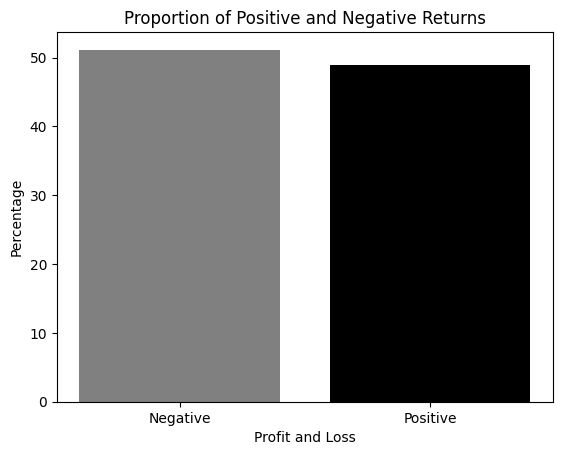

In [ ]:
# count of all the returns greater than 0
count = 0
for r in df['Returns']:
  if r > 0:
    count += 1
# creating a new column called returns where if returns are greater than 0 its labeled positive if not then negtive
df['P/L'] = df['Returns'].apply(lambda r: 'Positive' if r > 0 else 'Negative')

# showing the difference
prop_pos = count/len(df)

# Calculate proportions
pl_proportions = df['P/L'].value_counts(normalize=True)

# Plotting
plt.bar(pl_proportions.index, pl_proportions * 100, color=['grey', 'black'])
plt.title('Proportion of Positive and Negative Returns')
plt.xlabel('Profit and Loss')
plt.ylabel('Percentage')
plt.show()

-Proportion-

Looking at the amount that was positive and the amount that was negative the negative returns come out on top. We see slightly more than 50% of the time the return was negative in the last 24 years. The rest of the time it was postive which is not the thing you want to see as someone who is investing. however, as we know stocks are a complex thing and one part does not tell the whole story as it is muti-faceted.

In [ ]:
# Setting to date and getting year in df
df['year'] = pd.to_datetime(df['Date']).dt.year

# Calculate the rate of return and store them in a new DataFrame
yr_df_return = pd.DataFrame(columns=['year', 'Rate_of_Return'])
# iterating through the grouped years and pulling the first close amount and last close amont
for year, group in df.groupby('year'):
    open_amount = group.loc[group['Date'].idxmin()]['Close']  # First day of the year
    close_amount = group.loc[group['Date'].idxmax()]['Close']  # Last day of the year
# Calculate the rate of return using the above data (%)
    rate_of_return = ((close_amount - open_amount) / open_amount) * 100
# Bringing it together in a df
    yr_df_return = pd.concat([yr_df_return, pd.DataFrame({'year': [year], 'Rate_of_Return': [rate_of_return]})], ignore_index=True)

print(yr_df_return)
# avg rate of return
yr_df_return['Rate_of_Return'].mean()


    year  Rate_of_Return
0   1999       11.493540
1   2000      -26.724138
2   2001       42.624690
3   2002      -36.213992
4   2003       15.030408
5   2004        7.678864
6   2005      -15.907928
7   2006       18.388984
8   2007       11.133957
9   2008      -19.610278
10  2009       49.822594
11  2010       10.804077
12  2011       24.681313
13  2012        2.818035
14  2013       -4.471607
15  2014      -13.523419
16  2015      -15.080834
17  2016       22.096359
18  2017       -8.236139
19  2018      -26.307942
20  2019       16.344067
21  2020       -7.044750
22  2021        7.842504
23  2022        3.565128
24  2023        8.131402


3.1733958766318664

After doing some Exploratory Data Analysis we found some interesting points that show the overall health of the IBM stock. We actually notice that the average rate of retunr has beaten the average inflation rate that we mentioned above so that is out. We see some growth in this stock that gives some good returns especially in the recent years.

-Close Amount-

The average close amount is 129.72 with a STD of 35.33 showing there is some variance that can really spread this data out. The min close amount was 55 and the max is 215.8 showing the range here. However, that is from a long time ago before the big boom in this stock so this std is not as accurate as we look within the last year or so. There is much less variation now a days.


-Rate of Return (%)-
Looking at the percent return which is what most people will really want to know as they want to know how likely their odds are of making a profit. Looking at the percent return we notice that this stock has performed pretty well for the most part with an aveage rate of return of 3.17% in the last 24 years. However, online research shows its average at 6.1% showing that in the most recent years it has not been performing as well or has hit some big bumps on the way. The last 3 years have been a good performance with all of them being above the average and 2 of the years being more than double it.

One interesting point the year that we saw the biggest increase in stock price in a single day was the year 2000 however, the returns for that year were -26.72% which shows that it was a really volatile year. This is due to having the largest increase in a day and then having one of the largest negative returns on the year.


# Data Analysis/Models

**Model numbers will vary however, interpretation remains the same**

Starting the 2 multiple linear regression models to predict closing amount and returns.





In [ ]:
# Creating lagged columns
df['High_lag1'] = df['High'].shift(1)
df['Low_lag1'] = df['Low'].shift(1)
df['Volume_lag1'] = df['Volume'].shift(1)

# Dropping NaN values resulting from the lag
df = df.dropna().reset_index(drop=True)

# Getting IV
X = df[['Open', 'High_lag1', 'Low_lag1', 'Volume_lag1']]

# Getting DV
y = df['Close']

# Cross validation on data
# Linear model
model = LinearRegression()
# K-fold cross validation 5 fold
k_folds = KFold(n_splits = 5)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# getting the scores for cross vals
scores = cross_val_score(model, X, y, cv = k_folds)
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())


# Fit model
model.fit(X_train, y_train)

# predictions on model
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print(r2_score(y_test, y_pred))
# new data frame for pred and actual price and then i reset the index so it went from 1 up
dfr = pd.DataFrame({'Actual_Price': y_test,
                    'Predicted_Price': y_pred})
dfr.reset_index(drop=True, inplace=True)
dfr.index += 1
df_plot = dfr.head(100)

Cross Validation Scores:  [0.98632141 0.99629263 0.99877299 0.99678593 0.99326236]
Average CV Score:  0.9942870659927363
Mean Squared Error: 1.2238839762389657
Coefficients: [4.92175717e-01 2.06838031e-01 3.02426849e-01 3.50650209e-08]
Intercept: -0.27265647171699925
0.9990254495733346


Looking above we can see the results of the multiple linear regression which is extremely accurate. However, this is not a realistic strategy for predicting a stocks closing amount since we never know what is going to happen in the following day. That is why the accuracy is extremely high here. We get an R2 of ~99.9% meaning our Dependent variables variance is explained 99.9% by the indenpendent variables that have been introduced. However, looking into the coefficents we actually see some interesting numbers where the opening amount and volume are negative meaning they decrease the close amount as they rise. While low and high increase the close price by ~.77 each. Volume decrease it by 0.000000000982925519 which is an extremely small amount and open amount decrease by .537. This makes some sense as the high and low amounts increase the more likely the close amount will be increased as well. The stock will normally fall in that range however, there are the odd cases. Looking at volume it actually decreases the price and this may be saying something in correlation with economic beliefs that as the supply increases the less expensive something will normally be. However, this number is extremely small meaning they are in a fair market area stating they are meeting a good line between demand and supply. With the coefficent being this small it changing does not matter much currently. The opening amount have a negative correlation coefficent with close prices may be due to as the open amount rises people are more likely to sell their stocks and pull out making the closing price drop. There were some pretty interesting points here that validate some economic and stock beliefs meaning this regression is following the general trend of stocks.

I did run a cross validation method with k-folds to make sure that the results were even across my data. I wanted to rule out that maybe the portion of data for training that I used was bias in some way however, after running this it does not seem to be the case. While there is slight variation we notice a pretty consistent score of > 99%. The average was slightly lower than the single one I ran first showing that there is a smaller score in the other folds. This consistency is more evidence to support my claims above.



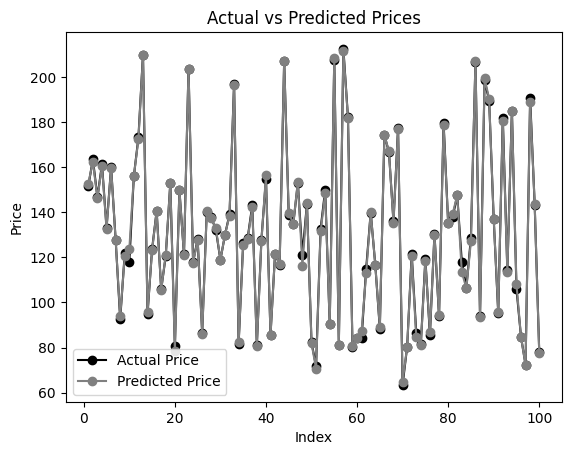

In [ ]:
import matplotlib.pyplot as plt


# Setting figure size to make it easier to see
plt.figure(figsize=(12, 6))

# Plotting actual prices
plt.plot(df_plot.index, df_plot['Actual_Price'], label='Actual Price', marker='o', color='black')

# Plotting predicted prices
plt.plot(df_plot.index, df_plot['Predicted_Price'], label='Predicted Price', marker='o', color='grey')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


We have already discussed the coefficents and R2 however, its always good to visualize and look at the performance of the model. Here we see how accurately the model was predicting in relation to the real data. The blue line is the actual price while red is predicted and for the most part it is right on the dot but there are some variations where the data is slightly off. From looking at the graph it appears that price has had a pretty good range. One thing to note that this is not chronological and is a mix up of dates and prices for them. But, just from looking at this we can see there have been some major shifts in the close price.

In [ ]:
# Getting IV
X = df[['Open', 'High_lag1', 'Low_lag1', 'Volume_lag1', 'Close']]

# Getting DV
y = df['Returns']

# Cross validation on data
# Linear model
model = LinearRegression()
# K-fold cross validation 5 fold
k_folds = KFold(n_splits = 5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# getting scores for new model
scores = cross_val_score(model, X, y, cv = k_folds)
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())


# Fit model
model.fit(X_train, y_train)

# predictions on model
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print(r2_score(y_test, y_pred))
# Data frame with actual and predicted returns
dfr = pd.DataFrame({'Actual_Return': y_test,
                    'Predicted_Return': y_pred})
dfr.reset_index(drop=True, inplace=True)
dfr.index += 1
df_plot = dfr.head(100)

Cross Validation Scores:  [0.84727368 0.76547145 0.5868885  0.70814938 0.73298697]
Average CV Score:  0.7281539965377937
Mean Squared Error: 6.217697999530082e-05
Coefficients: [-1.44429692e-04 -4.86148208e-03 -5.00809419e-03 -6.92398092e-11
  1.00111430e-02]
Intercept: 0.0005975737541966429
0.783160464815849


When we run the regression for predicting Returns using Opening amount and the High,Low, and Volume of the previous day we were able to get an R2 of 74.7%. This is pretty good and a little more accurate than using the current day data to make predictions as we would not have that data avaliable. The cross validation actually showed that the data had some inconsistency in it and showed the value of cross validation. For example it ranges from as low as 58.6% to as high as 84.7% which is a big gap between them. The average of 72.8% was pretty close to what our current model runs.

Now lets look at the coefficents where they are listed below:

Coefficents

* Open Amount = -.00015
* High Amount from Previous Day = -.00501
* Low Amount from Previous Day = -.00475
* Volume from Previous Day = -.00000000000193
* Close Amount from Previous Day = .00993

There are 4 negative coefficents and 1 postive which is telling me that the higher Open, High, Low, and Volume is the lower the odds of a postive return. However, Close Amount has a small positive impact on that. The goal in stocks is to make money and hop on the stock at the lowest amount and ride it to the top however, people gauge numbers differently meaning they may jump off sooner. Thats what these numbers are showing. The higher the Open amount or High and low amounts the more likely people will pull their money to try and capitalize on that big amount. However, once the amount is closed for the day the return will climb the next day and people will wait to see how it plays out then. Thats the general story we are seeing here however, we do not see the random chance of the stock busting or exploding as there is no way to account for that with this current model. Now lets take a look at the results of this model visually with a graph showing the actual results to our predictions.

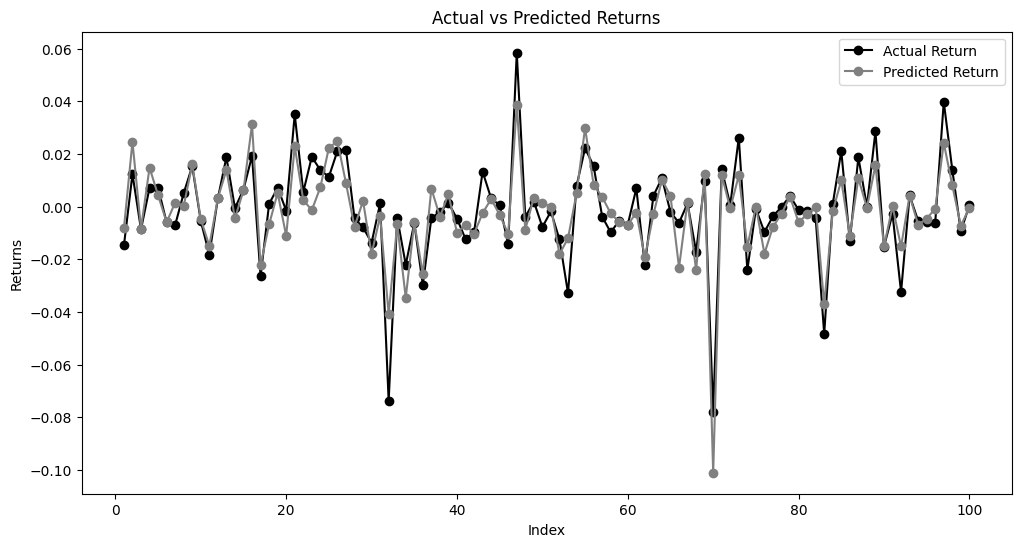

In [ ]:
import matplotlib.pyplot as plt
# figure size the same again
plt.figure(figsize=(12, 6))

# Plotting actual prices
plt.plot(df_plot.index, df_plot['Actual_Return'], label='Actual Return', marker='o', color='black')

# Plotting predicted prices
plt.plot(df_plot.index, df_plot['Predicted_Return'], label='Predicted Return', marker='o', color='grey')

plt.title('Actual vs Predicted Returns')
plt.xlabel('Index')
plt.ylabel('Returns')
plt.legend()
plt.show()


Here we see the predicted vs the actual and it appears that it lines up pretty well. However, you can our model is a little more conservative on the high numbers and a little more likely to say a lower number. One thing we also get a peak at here is the Returns price on the side. We can see that for the most part it rides around the 0 mark but jumps slightly more toward the positive side. This is good and means that the stock is slowly growing over time in price.

# Conclusion

My final evaluation on the health of the stock show that this stock is mostly healthy despite some bad numbers. While the proportion shows that we are more likely to get a negative return compared to a positive one we notice that overall returns are positive. Taking the averge of all returns we got ~ 3.17% which shows that it is going to grow. However, whether or not it keeps up with inflation like the S&P 500 does is another story as it appears it may just break even or fall below it. This shows the stock is doing okay however, I do not think this is one to invest in if you aren't already. I would rather have money in the S&P 500 due to a higher and more consistent return. However, as you know stocks are hard to make calls on and with the tech boom lately it's possible we could see IBM grow significantly. It would be one to watch for now if you are already invested or if a new break through is on the horizon which I suspect there is.

For the regression we performed a multiple linear regression with the DV being close amount and the IV being open, high, low, and volume. This means we are trying to predict closing amounts with these IV's which showed a very high and accurate prediction rate. While it may seem very high I do not think it is a realistic number as there is far more that would go into the complicated field of stocks. Another regression was run with the same 4 IVs and adding the Close amount as well. The DV we wanted to predict this time was returns. People want to know if they are going to make money on a stock. This regression showed a pretty high and accurate prediction rating of 74.7% which isn't as high as the previous one. But, this one seems to a be a little harder to pin down as we were missing out on explaining a good 25% of variance in the DV. More research would be needed to pan this out.

# References
* Mergent. (n.d.). IBM Historical Stock Lookup. Retrieved from https://ibm.gcs-web.com/stock-information/historic-stock-lookup
* Vantage, A. (2023, 11 24). Alpha Vantage API Documentation. Retrieved from Alpha Vantage: https://www.alphavantage.co/documentation/

